# **EvoMol: Evolutionary design of molecules**

EvoMol is a flexible and interpretable evolutionary algorithm designed for molecular properties optimization. Using simple rules for the mutation of an original population of molecule graphs, it can optimize any (customizable) objective function and maximize the diversity of generated molecules.

Let us see how it works and how to make use of its most basic functionalities. 

Mount the drive folder in collab and install dependencies

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

repsol_path = '/content/repsol-ml4md'
your_path = '/content/drive/MyDrive/Proyectos/repsol-ml4md/generative_models/evolutionary_algorithm'  # Change your path here wherever you may need it to be
os.symlink(your_path, repsol_path) 

Mounted at /content/drive


In [3]:
# Install dependencies
%pip install cclib
%pip install rdkit
%pip install guacamol

# For visualization purposes
!apt install libgraphviz-dev
%pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.5/752.5 kB 53.2 MB/s eta 0:00:00
  Created wheel for cclib: filename=cclib-1.7.2-py3-none-any.whl size=317969 sha256=d7d7155f86353fba44e56dbdaa7f7cfeef02e974c2ef22708e44c2283fac87e3
  Stored in directory: /root/.cache/pip/wheels/3a/dc/5b/587a22862cb9f2b706fb170e6683babc8b8da723953dffb3e8
Successfully built cclib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

The `EvoMol` code needs to be installed using the original repository implementation. The algorithm is maintained regularly by the authors, and there is a lot of useful information encoded that we can already use. 

In order to install the code, we must download EvoMol and install it.

In [4]:
!git clone https://github.com/jules-leguy/EvoMol.git
%pip install EvoMol/.

Cloning into 'EvoMol'...
remote: Enumerating objects: 1932, done.
remote: Counting objects: 100% (309/309), done.
remote: Compressing objects: 100% (285/285), done.
remote: Total 1932 (delta 58), reused 248 (delta 24), pack-reused 1623
Receiving objects: 100% (1932/1932), 18.56 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (813/813), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./EvoMol
  Preparing metadata (setup.py) ... done
  Created wheel for EvoMol: filename=EvoMol-1.5.1-py3-none-any.whl size=94973 sha256=9692d681290a897bda74c305a30f6e0354a4016fa3f7e43bec6085890bfc9dde
  Stored in directory: /tmp/pip-ephem-wheel-cache-htr0n07u/wheels/34/36/ed/9247d0889add99b5a210dd05baf8f3ee782b88189da096873f
Successfully built EvoMol


Load the path to the model and import the relevant packages

In [5]:
evomol_path = '/content/repsol-ml4md/EvoMol'
sys.path.insert(0,evomol_path)

In [6]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Evomol functions
from evomol import run_model
from evomol.plot_exploration import exploration_graph

# RDkit for everything else
import rdkit
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem, Draw

# **Evolutionary steps**

The evolutionary algorithm implemented in EvoMol enables step-by-step evolution of compounds in order to optimize a given objective function. Once an initial population of molecules is defined and the objective function is described in an explicit manner, the algorithm is run in order to evolve that initial population of molecules (_can be only one molecule_) into a population with a better measure in the objective function. To that end, the **following transformations** are allowed inside the evolutionary algorithm:

<img src = 'https://drive.google.com/uc?id=1hcqXQFhFWzyp_sdlaUwFLIomnwG9Z8Ii'>

Combining these actions with the initial population, we evolve it until we reach the stopping criteria stablished (maximum number of evolutionary steps, threshold on the objective function, size of the population reached, etc).


## **Settings**

`EvoMol` can be run using a simple dictionary of arguments, specifying all the details about the specific run we may be interested in. This dictionary should contain up to *4 entries* describing the complete experiment, although each one of these entries is pretty flexible and will allow us to conduct many different tests.

*Note:* Default values are represented in **bold**.

We must define some things before we can actually use the code. Let us go step-by-step with the four main parts to define the run, and then apply these contents to an evolutionary chain.

### **1. Objective function**

The attribute `obj_function` can take a lot of different values. Moreover, as we will see, multi-objective functions can also be defined in a nested manner (with any desired depth). 

* Implemented functions: 
  * There are several functions already implemented:
    * "<a href="https://www.nature.com/articles/nchem.1243">qed</a>": Quantitative estimate of drug-likeness. Other alternative drug-likeness measures may be considered here, such as the _Lipinski Rule of 5_, although the QED metric seems to provide better results. 
    \begin{equation}
    \text{QED} = \exp \left( \frac{1}{n} \sum_{i=1}^n \log d_i\right),
    \end{equation}
    with _d_ some desirability function for the molecular descriptor of interest.
    * "<a href="https://arxiv.org/abs/1610.02415v2">plogp</a>": Logp is the water-octanol partition coefficient, also characterizing the drug-likeness of a molecule. 'plogp' is `logp` minus the synthetic accesibility (SA) score and the number of long cycles.
    * "<a href="https://www.nature.com/articles/s41598-019-47148-x">norm_plogp</a>": Normalized version of the `plogp` 
    * "<a href="https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8">sascore</a>": Synthetic accesibility score. It is usually described in terms of `fragment_score` (a number that attempts to capture the _historical synthetic knowledge_ of already synthesized molecules) minus the `complexity_score` (which caracterizes the presence of complex structural features, such as large rings, non-standard ring fusions, stereocomplexity and molecule length).
    * "<a href="https://arxiv.org/abs/1705.10843">norm_sascore</a>" Normalized SA score
    * "<a href="https://www.frontiersin.org/articles/10.3389/fchem.2020.00046/full">clscore</a>":  ChEMBL-likeness score, a combination between the SA score and the <a href="https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-13-106">natural product likeness score</a>.   
    * `n_perturbations` count of the number of perturbations that were previously applied on the molecular graph during the optimization. If the `mutation_max_depth` parameter is set to 1, then this is equivalent to the number of mutations.

  > Others:
  >
  > * <sup><sub> <a href=https://pubs.acs.org/doi/10.1021/acs.jcim.8b00839>isomer</a>_formula" (*e.g.* "isomer_C7H16"), where the task is to generate molecules that correspond to a target molecular formula. </sub></sup>
  * <sub><sup> "<a href=https://pubs.acs.org/doi/10.1021/acs.jcim.8b00839>rediscovery</a>_smiles" (*e.g.* "rediscovery_CC(=O)OC1=CC=CC=C1C(=O)O") </sub></sup>
  * <sub><sup> Several metrics regarding the entroy are also implemented. As examples we have `entropy_ifg`, `entropy_gen_scaffolds`, `entropy_shg_1`, `entropy_checkmol` and `entropy_ecfp4`. These can be used to maximize the entropy of descriptors, using respectively <a href="https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0225-z">IFGs </a>, <a href="https://pubs.acs.org/doi/10.1021/jm9602928">Murcko generic scaffolds</a>, level 1 <a href="https://link.springer.com/article/10.1186/s13321-018-0321-8">shingles</a>, <a href="https://homepage.univie.ac.at/norbert.haider/cheminf/cmmm.html">checkmol</a> and ECFP4 fingerprints (`RDKit` Morgan fingerprints implementation). </sub></sup>
  * <sub><sup> `sillywalks_proportion`: proportion of _ECFP4_ features that failed the [sillywalks filter](https://github.com/PatWalters/silly_walks), based on the reference dataset given in the `silly_molecules_reference_db_path` parameter. </sub></sup>
  * <sub><sup> `homo`, `lumo`, `gap`, `homo-1`: Some metrics ara available regarding the occupied orbital energy of the atoms. In this case, we have _HOMO_ (_Highest Occupied Molecular Orbital_), LUMO (_Lowest Unoccupied Molecular Orbital_), GAP (_HOMO-LUMO difference_) and HOMO-1 (_next-to-highest Occupied Molecular Orbital_, also _NHOMO_). </sub></sup>
* A **custom function** evaluating a SMILES. It is also possible to give a tuple (function, string function name).
* A **dictionary** describing a **multi-objective function** and containing the following entries:
    * `type` : 
      * "linear_combination" (linear combination of the properties).
      * "product" (product of the properties).
      * "mean" (mean of the properties).
      * "abs_difference" (absolute difference of **exactly 2** properties).
    * `functions` : list of functions (string keys describing implemented functions, custom functions,
    multi-objective functions or wrapper functions).
    * When using a linear combination of functions: 
        * `coef` : list of coefficients.
* A **dictionary** describing a **function wrapping a single property** and containing the following entries:
  * `type`:
     * "gaussian" (passing the value of a unique objective function through a Gaussian function).
     * "opposite" (computing the opposite value of a unique objective function).
     * "sigm_lin", (passing the value of a unique objective through a linear function and a sigmoid function).
     * "one_minus" (computing 1-f(x) of a unique objective function f).
  * `function` the function to be wrapped (string key describing an implemented function, custom function,
  multi_objective function or wrapper function)
  * Specific to the use of a Gaussian function
    * `mu`: Gaussian mean.
    * `sigma`: Gaussian standard deviation.
    * `normalize`: whether to normalize the function so that the maximum value is exactly 1 (**False**).
  * Specific to the use of sigmoid/linear functions
      * `a` list of $a$ coefficients for the $ax+b$ linear function definition.
      * `b` list of $b$ coefficients for the $ax+b$ linear function definition.
      * `lambda` list of $\lambda$ coefficients for the sigmoid function definition.
* An instance of `evomol.evaluation.EvaluationStrategyComposant`
* `guacamol_v2` for taking the goal directed <a href="https://pubs.acs.org/doi/10.1021/acs.jcim.8b00839">
GuacaMol</a> benchmarks.


**Example**:

Let us make an example to define this part of the input to the model

In [7]:
# Simple evaluation function, only using QED as objetive 
simple_obj_function = {
    "obj_function":"qed"
}

More advanced version of evaluation function. Here we employ the number of _heteroatoms_ (atoms other than C or H) as a metric. We are thus using the last option to define the function (dictionary to define a function that wraps over a single-valued function).

In [8]:
from rdkit.Chem import Lipinski, MolFromSmiles

# Function to define the proportion of heteroatoms in the molecule
def hetero_atoms_proportion(smiles):
    return Lipinski.NumHeteroatoms(MolFromSmiles(smiles)) / Lipinski.HeavyAtomCount(MolFromSmiles(smiles))

advanced_eval_function = {
    "obj_function":{
        "type": "mean",
        "functions": [
            {
                # Evaluation strategy passing the value of the evaluator through a Gaussian function
                "type": "gaussian",
                # Using our custom function and naming the sub-objective
                "function": (hetero_atoms_proportion, "hetero_atoms_proportion"), 
                # Gaussian parameters
                "mu": 0.3,
                "sigma": 0.1,
                "normalize": True
            },
            "qed"
        ]
    }
}

We will see how to use these later


## **2. Search space**

The `action_space_parameters` attribute degines parameters for the actions that can take place under the evolutive chain. The attribute can be defined via a dictionary containing the following entries:
* `atoms` : Text list of available <ins>heavy</ins> atoms (for the most part, we will restrict to the collection of **C, N, O, F, P, S, Cl, Br**, although more heavy atoms can be specified here as well if needed).
* `max_heavy_atoms`: Maximum molecular size in terms of number of heavy atoms (**38**).
* `append_atom`: Whether to use **append atom** action (**True**).
* `remove_atom`: Whether to use **remove atom** action (**True**).
* `change_bond`: Whether to use **change bond** action (**True**).
* `change_bond_prevent_breaking_creating_bonds`: whether to prevent the removal or creation of bonds by *change_bond* action (**False**) 
* `substitution`: Whether to use *substitute atom type* action (**True**).
* `cut_insert`: Whether to use *cut atom* and *insert carbon atom* actions (**True**).
* `move_group`: whether to use *move group* action (**True**).
* `remove_group`: Whether to use *remove group* action (**False**).
* `remove_group_only_remove_smallest_group`: In case _remove group_ action is enabled, whether to be able to remove both parts of a bridge bond (**False**), or only the smallest part in number of atoms (**True**).
* `custom_filter_function`: *Custom boolean function* evaluating a SMILES that defines a filter on the accessible search space. If the result is `True`, the molecule is considered valid, and otherwise it is considered invalid (**None**). (_Note:_ This can be used to filter **instances** out of a particularly interesting **schema**).
* `sascore_threshold` If a solution has a SA score value above this threshold, they will be discarded and thus will not be inserted in the population (**float("inf")**).

> Others:
>
> * <sub><sup> `use_rd_filters`: Whether to use the <a href=https://github.com/PatWalters/rd_filters>rd_filter program</a> as a 
quality filter before inserting the mutated individuals in the population (**False**). </sub></sup>
* <sub><sup> `sillywalks_threshold``` Maximum proportion of [silly bits](https://github.com/PatWalters/silly_walks) in the ECFP4 
fingerprint of the solutions with respect to a reference dataset (see IO parameters). This serves to filter out and to identify "odd" parts in molecules (_e.g._ odd rings). If the proportion is above a given threshold, the solutions will be discarded and thus will not be inserted in the population (**1**). </sub></sup>
* <sub><sup> `sulfur_valence`: Valence of sulfur atoms (**6**).</sub></sup>

In [9]:
# Simple function to cut the number of heavy atoms in 5

simple_action_parameters = {
            "max_heavy_atoms" : 5,
            "change_bond" : False,
            "remove_group" : False,
            "sascore_threshold" : 10000
}

## **3. Optimization parameters**

The `optimization_parameters` attribute controls the run of the evolutionary chain. Here we must set up all parameters regarding the population control, mutation process, starting points, etc. Again, this can be set up using a dictionary, containing all of the following fields:
* `pop_max_size` : Maximum population size (**1000**).
* `max_steps` : Maximum number of evolutionary steps (**1500**).
* `max_obj_calls`: Maximum number of calls to the objective functions (**float("inf")**). To be used in cases where this function access is limited in some sense (_e.g._ optimization purposes).
* `k_to_replace` : Number of individuals replaced at each step (**10**).
* `selection` : Whether the best individuals are selected to be mutated (**`best`**), or they are selected randomly with uniform distribution (`random`), or they are selected randomly with a probability that is proportional to their objective function value (`random_weighted`) .
* `problem_type` : Select whether the objective function should be maximized (**"max"**) or minimized ("min").
* `mutation_max_depth` : Maximum number of successive actions on the molecular graph during a single mutation (**2**).
* `mutable_init_pop` : If `True`, the individuals of the initial population can be freely mutated. If `False`, they can be branched but their atoms and bonds cannot be modified (**True**). Can be used to construct **schemas**.
* `shuffle_init_pop`: Whether to shuffle the smiles at initialization (**False**).

> Others
>
> * <sub><sup> `neighbour_generation_strategy`: Strategy to generate neighbour candidates (mutation). By default, the type of perturbation is first drawn randomly, then the actual perturbation of previously selected type is drawn randomly among the valid ones (**evomol.molgraphops.exploration.RandomActionTypeSelectionStrategy()**). </sub></sup>
* <sub><sup> `mutation_find_improver_tries` : Maximum number of mutations to find a candidate for improvement (**50**). </sub></sup>
* <sub><sup> `stop_kth_score_value`: Stop the search process if the $k$-th score in the descendant value has reached the set value with the set precision. Accepts a tuple `(k, score, precision)`, or can be disabled using **`None`**  (default). </sub></sup>
* <sub><sup> `guacamol_init_top_100` : Whether to initialize the population with the 100 best scoring individuals of the <a href="https://academic.oup.com/nar/article/45/D1/D945/2605707">GuacaMol ChEMBL</a> subset in case of taking the GuacaMol benchmarks (**False**). The list of SMILES must be given as initial population. </sub></sup>
* <sub><sup> `n_max_desc`: Maximum number of descriptors handled when using an evaluator relying on a vector of descriptors such as entropy contribution (**3.000.000**). </sub></sup>

In [10]:
simple_opt_parameters = {
        "max_steps": 10,
        "k_to_replace": 5,
        "mutable_init_pop": False   # To maintain initial population as a schema
}

## **4. Input-Output parameters**

Finally, the `io_parameters` attribute contains the parameters regarding the context for each run. This goes from the paths to files to be saved by the execution, the initial population smiles, the steps saved by the evolutionary chain and extra calculations. Again, this is set via a dictionary containing the following fields: 
* `model_path` : Path to save the model's output data (**"EvoMol_model"**).
* `smiles_list_init`: List of SMILES for the initial population (**None**: interpreting the `smiles_list_init_path` attribute).
* `smiles_list_init_path` : Path to the SMILES list text file describing the initial population (_one SMILES per row_). It is also possible to pass the path to the *pop.csv* file from a previous _EvoMol_ experimental run. In this last case, the population will be initialized as it was at the end of the loaded experiment (**None**: initialization of the population with **a single methane molecule**).
* `external_tabu_list`: List of forbidden SMILES (will not be generated by EvoMol).
* `record_history` : Whether to save exploration tree data. Must be set to`True` to later draw the exploration tree (**False**).
* `record_all_generated_individuals` : Choose whether to record a list of all individuals that are generated during the entire execution (even if they fail the objective function computation or if they are not inserted in the population as they are not improvers). Also records the step number and the total number of calls to the objective function at the time of generation (**False**).
* `save_n_steps` : Evolutionary steps (periods) for saving the data (**100**).
* `print_n_steps` : Evolutrionary steps (periods) for printing current population statistics (**1**).

> Others:
>
> <sub><sup> * `dft_working_dir` : Path to save DFT optimization related files (**"/tmp"**). </sub></sup>
* <sub><sup> `dft_cache_files` : List of json files containing a cache of previously computed _HOMO_ or _LUMO_ values (**[]**). </sub></sup>
* <sub><sup> `dft_MM_program` : Program used to compute molecular mechanics initial geometry of DFT calculations. The options are : </sub></sup>
  * <sub><sup>"**obabel_mmff94**" or "obabel" to combine OpenBabel and the MMFF94 force field. </sub></sup>
  * <sub><sup>"rdkit_mmff94" to combine RDKit with the MMFF94 force field. </sub></sup>
  * <sub><sup> "rdkit_uff" to combine RDKit with the UFF force field. </sub></sup>
* <sub><sup>`dft_base`: DFT calculations base (__"3-21G*"__).</sub></sup>
* <sub><sup>`dft_method` : DFT calculations method (**B3LYP**).</sub></sup>
* <sub><sup>`dft_n_jobs`: Number of threads assigned to each DFT calculation (**1**). </sub></sup>
* <sub><sup>`dft_mem_mb`: Memory assigned to each DFT calculation, in MB (**512**).</sub></sup>
* <sub><sup>`silly_molecules_reference_db_path`: Path to a JSON file that that represents a dictionary to contain as keys all the ECFP4 bits that are extracted from a reference dataset of quality solutions (**None**). See the `sillywalks_threshold` parameter.</sub></sup>
* <sub><sup> `evaluation_strategy_parameters` : Dictionary that contains an entry "evaluate_init_pop" to set given parameters to the EvaluationStrategy instance in the context of the evaluation of the initial population. An entry  "evaluate_new_sol" must be also contained to set given parameters for the evaluation of new solutions during the  optimization process. If None, both keys are set to an empty set of parameters (**None**).</sub></sup>


In [15]:
model_path = f'{repsol_path}/examples/simple_io'

simple_io_parameters = {
        "model_path": model_path,
        "record_history": True
}

# **Run the model**

We can run everything using the simple functions we have defined thus far. 

In this case, the objective function is treated a bit different since the `simple_obj_function` dictionary only contains a single entry with the call to the desired function (`qed`), but if we had any more entries it will be enough to employ the same format as with the remaining parameters.

In [16]:
run_model({**simple_obj_function,
           'action_space_parameters' : {**simple_action_parameters}, 
           'optimization_parameters' : {**simple_opt_parameters}, 
           'io_parameters' : {**simple_io_parameters}})

SYMBOLS LIST : ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
objective_calls
Computing scores at initialization...
Start pop algorithm
qed_mean : 0.35978
qed_med : 0.35978
qed_std : 0.00000
qed_min : 0.35978
qed_max : 0.35978
total_mean : 0.35978
total_med : 0.35978
total_std : 0.00000
total_min : 0.35978
total_max : 0.35978
new step
step : 0
best : C
qed_mean : 0.36629
qed_med : 0.36629
qed_std : 0.00650
qed_min : 0.35978
qed_max : 0.37279
total_mean : 0.36629
total_med : 0.36629
total_std : 0.00650
total_min : 0.35978
total_max : 0.37279
new step
step : 1
best : CC
qed_mean : 0.38196
qed_med : 0.36903
qed_std : 0.02811
qed_min : 0.35978
qed_max : 0.42999
total_mean : 0.38196
total_med : 0.36903
total_std : 0.02811
total_min : 0.35978
total_max : 0.42999
new step
step : 2
best : CCCF
qed_mean : 0.39277
qed_med : 0.38207
qed_std : 0.02948
qed_min : 0.35978
qed_max : 0.44739
total_mean : 0.39277
total_med : 0.38207
total_std : 0.02948
total_min : 0.35978
total_max : 0.44739
new step
step :

We can now show some of the results from this previous test run. To do so, we explore some of the files generated by the execution.

In [17]:
pop = pd.read_csv(f'{model_path}/pop.csv')
steps = pd.read_csv(f'{model_path}/steps.csv')

In the `pop.csv` file we have the generated population of molecules under the evolutionary algorithm. We can actually take a look a the complete population, including information regarding the value of the function we have defined as an optimization target in the model run. 

In [18]:
pop.head()

,smiles,n_success_mut,n_failures_mut,qed,total,obj_computation_time,history_data
0,C,3,0,0.359785,0.359785,0.001581,C
1,CC,2,0,0.372786,0.372786,0.002187,C|AddA-8
2,CCCF,4,0,0.429991,0.429991,0.002626,C|AddA-8|AddA-11_InsA-0
3,CCP,1,0,0.365283,0.365283,0.001051,C|AddA-12_InsA-0
4,CCCS,4,0,0.447388,0.447388,0.001077,C|AddA-8|AddA-11_InsA-0|Sub-21


The `steps.csv` records the evolutionary steps that took place during the complete run. For every time step taken, it includes information about the evaluation of the objective metric and extra information about filters and other checks that may have been used during the evolution process.

In [19]:
steps.head()

,qed_mean,qed_med,qed_min,qed_max,qed_std,total_mean,total_med,total_min,total_max,total_std,...,n_replaced,timestamps,n_failed_obj_computation,n_not_improvers_among_success_obj_computation,n_discarded_tabu,n_discarded_filters,n_discarded_rdfilters,n_discarded_sillywalks,n_discarded_sascore,n_discarded_custom_filter
0,0.359785,0.359785,0.359785,0.359785,0.000000,0.359785,0.359785,0.359785,0.359785,0.000000,...,0,0.009383,0,0,0,0,0,0,0,0
1,0.366285,0.366285,0.359785,0.372786,0.006500,0.366285,0.366285,0.359785,0.372786,0.006500,...,1,0.022812,0,0,4,0,0,0,0,0
2,0.381961,0.369034,0.359785,0.429991,0.028111,0.381961,0.369034,0.359785,0.429991,0.028111,...,2,0.075422,0,0,1,0,0,0,0,0
3,0.392773,0.382068,0.359785,0.447388,0.029485,0.392773,0.382068,0.359785,0.447388,0.029485,...,4,0.093715,0,0,1,0,0,0,0,0
4,0.396770,0.385284,0.359785,0.454269,0.029914,0.396770,0.385284,0.359785,0.454269,0.029914,...,5,0.119510,0,0,2,0,0,0,0,0


We can plot the molecules with the best values found for the desired objective function using the population dataset

In [20]:
best_compounds = pop.sort_values(by = "qed", ascending=False)[['smiles', 'qed']].iloc[:12]
print( best_compounds )

rd_molecules = [Chem.MolFromSmiles(molecules) for molecules in best_compounds['smiles']]
Draw.MolsToGridImage(rd_molecules, 
                     molsPerRow=6, 
                     subImgSize=(200,200)) 

         smiles       qed
32  CC[SH](C)Br  0.552271
25        CCCCN  0.512415
39        CCCNC  0.504854
24        CCCSF  0.504084
29        CCSPF  0.493339
20        CCCCS  0.490253
40     CC(Br)CF  0.487556
41        FCCSP  0.487371
33   CC[SH](C)F  0.470012
30        NCCCS  0.468502
28        CCOCN  0.466505
38   CC[SH](C)O  0.466288


Using the implemented functions inside EvoMol, we can actually plot the complete evolutionary tree 

layout computed


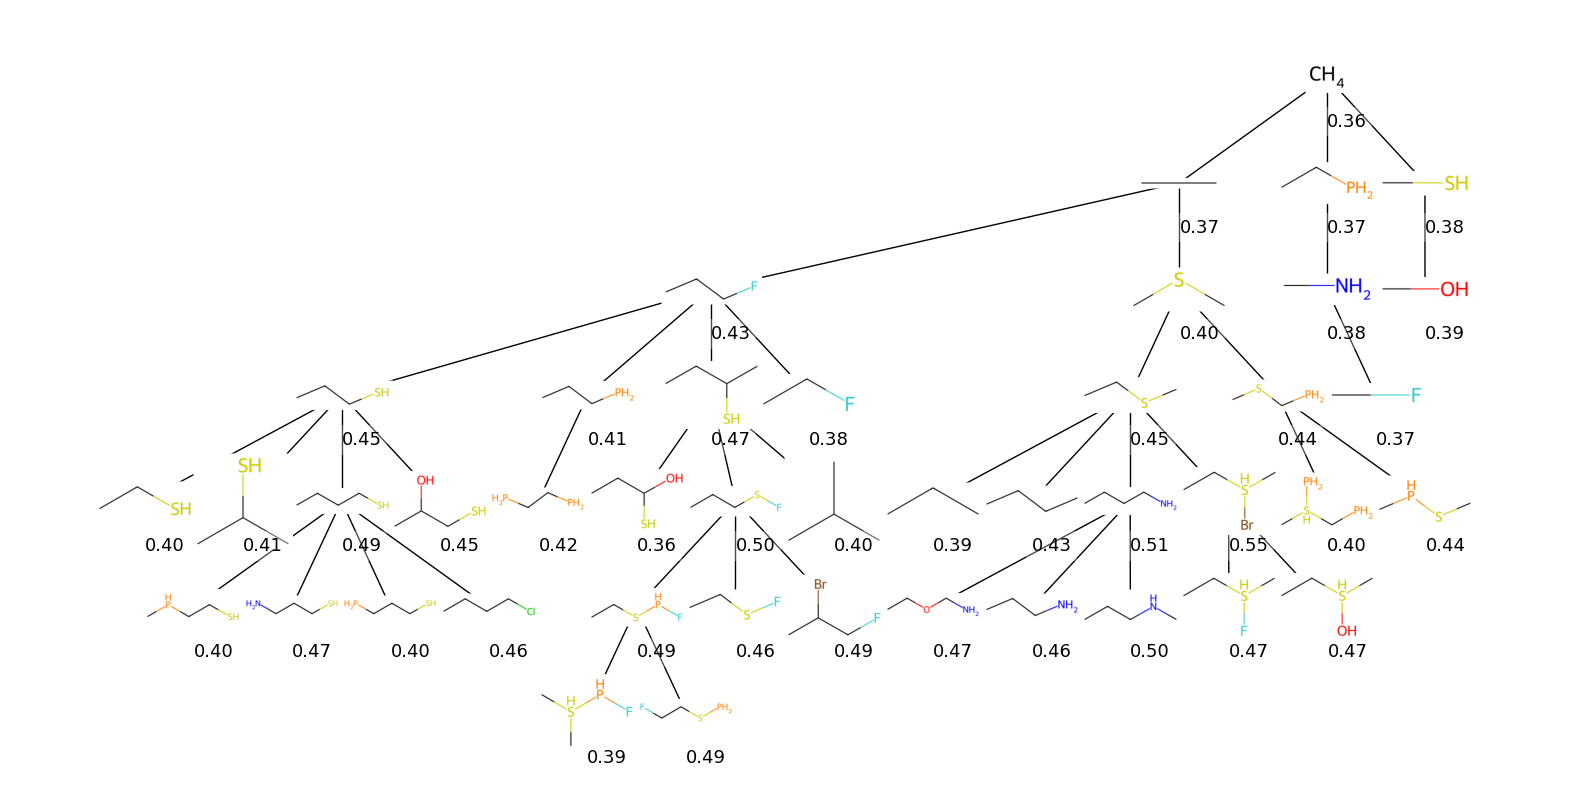

In [22]:
exploration_graph(model_path=model_path, 
                  layout= 'dot', # Graphviz layout (e,g, 'dot', 'neato', 'circo', 'twopi', 'sfdp' - for more, check https://graphviz.org/docs/layouts/)
                  # draw_actions=True, # Draw the action taken for each branch
                  plot_images=True, 
                  draw_scores=True,
                  root_node="C", # Select the root node
                  legend_scores_keys_strat=["total"], 
                  mol_size_inches=0.1,
                  mol_size_px=(200, 200), 
                  legend_offset=(0, -0.05), 
                  figsize=(20, 10), 
                  legends_font_size=13)

## Alternative objective function (Penalized logP)
We can try everything again, but changing the objective function so as to see how it affects the generated population of molecules

In [23]:
# Select a different path to save the model
model_path = f'{repsol_path}/examples/logp_simple_run'

simple_io_parameters = {
        "model_path": model_path,
        "record_history": True
}

# Change from QED to PlogP
run_model({'obj_function' : 'plogp',   
           'action_space_parameters' : {**simple_action_parameters}, 
           'optimization_parameters' : {**simple_opt_parameters}, 
           'io_parameters' : {**simple_io_parameters}})

SYMBOLS LIST : ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
objective_calls
Computing scores at initialization...
Start pop algorithm
penalized_logP_mean : -6.69232
penalized_logP_med : -6.69232
penalized_logP_std : 0.00000
penalized_logP_min : -6.69232
penalized_logP_max : -6.69232
total_mean : -6.69232
total_med : -6.69232
total_std : 0.00000
total_min : -6.69232
total_max : -6.69232
new step
step : 0
best : C
penalized_logP_mean : -5.05665
penalized_logP_med : -5.05665
penalized_logP_std : 1.63567
penalized_logP_min : -6.69232
penalized_logP_max : -3.42098
total_mean : -5.05665
total_med : -5.05665
total_std : 1.63567
total_min : -6.69232
total_max : -3.42098
new step
step : 1
best : CN
penalized_logP_mean : -3.57520
penalized_logP_med : -2.94357
penalized_logP_std : 1.89782
penalized_logP_min : -6.69232
penalized_logP_max : -1.72137
total_mean : -3.57520
total_med : -2.94357
total_std : 1.89782
total_min : -6.69232
total_max : -1.72137
new step
step : 2
best : CC
penalized_logP_mean 

           smiles  penalized_logP
35           CCCC        0.200677
26  ClC(Cl)(Cl)Br       -0.642188
20        CC(C)Cl       -0.652354
18          CCCCl       -0.732400
34       CCC(C)Cl       -0.811048
40        ClCCCBr       -0.930505
4            CCCl       -1.136234
15      ClC(Cl)Br       -1.145327
30           CCCF       -1.215115
33   SC(Cl)(Cl)Cl       -1.231613
32     ClC(Cl)CBr       -1.238156
19       CC(Cl)Br       -1.293990


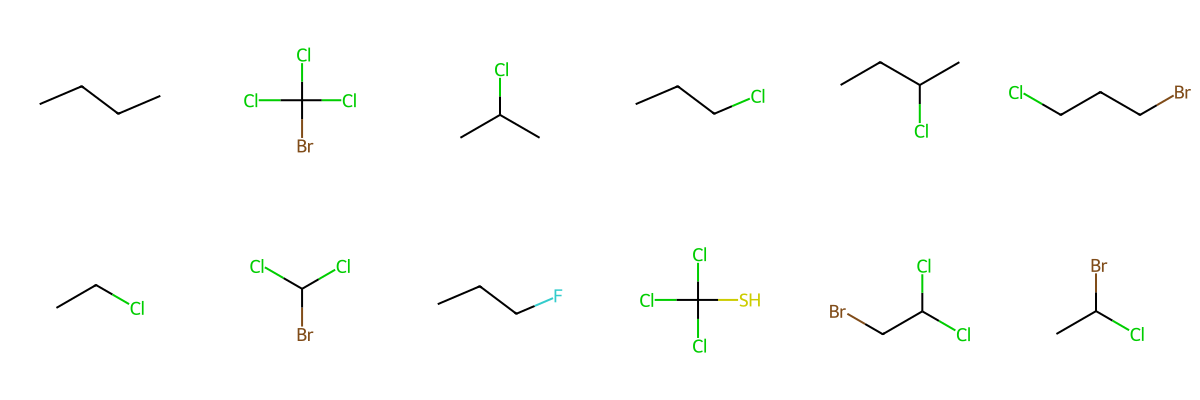

In [24]:
# Show the best compounds
pop_plogp = pd.read_csv(f'{model_path}/pop.csv')
best_plogp = pop_plogp.sort_values(by = "penalized_logP", ascending=False)[['smiles', 'penalized_logP']].iloc[:12]
print(best_plogp)

rd_molecules_plogp = [Chem.MolFromSmiles(molecules) for molecules in best_plogp['smiles']]
Draw.MolsToGridImage(rd_molecules_plogp, 
                     molsPerRow=6, 
                     subImgSize=(200,200))

layout computed


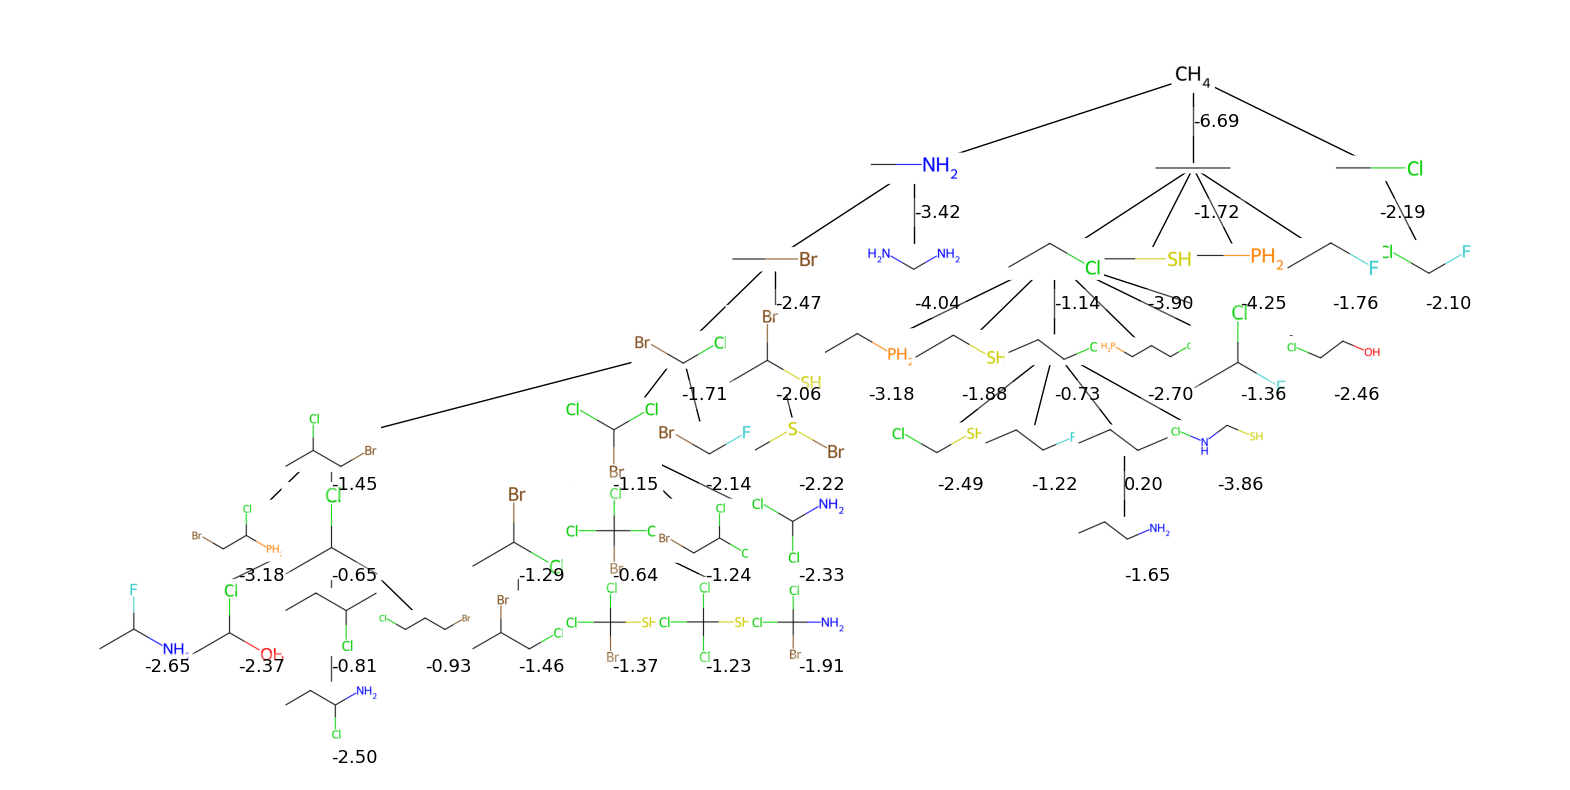

In [25]:
# Plot the tree
exploration_graph(model_path=model_path, layout= 'dot', plot_images=True, draw_scores=True, legend_scores_keys_strat=["total"], mol_size_inches=0.1, mol_size_px=(200, 200), 
                  legend_offset=(0, -0.05), figsize=(20, 10), legends_font_size=13)

## Tailored function (heteroatom proportion and QED)

We will now use the more complex function we defined earlier, the one that employed the heteroatom proportion in each molecule. Keep in mind that, by default, the model tries to maximize the objective, and therefor in this case (just as a simple example) we will try to look for molecules that maximize QED and the heteroatom proportion. 

In [26]:
# Re-do the process with the explicitly defined heteroatom function
model_path = f'{repsol_path}/examples/advanced_eval_function'

simple_io_parameters = {
        "model_path": model_path,
        "record_history": True
}

# Change from QED to PlogP
run_model({**advanced_eval_function,   
           'action_space_parameters' : {**simple_action_parameters}, 
           'optimization_parameters' : {**simple_opt_parameters}, 
           'io_parameters' : {**simple_io_parameters}})

SYMBOLS LIST : ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
objective_calls
Computing scores at initialization...
Start pop algorithm
X̅(Gaussian(hetero_atoms_proportion); qed)_mean : 0.18545
X̅(Gaussian(hetero_atoms_proportion); qed)_med : 0.18545
X̅(Gaussian(hetero_atoms_proportion); qed)_std : 0.00000
X̅(Gaussian(hetero_atoms_proportion); qed)_min : 0.18545
X̅(Gaussian(hetero_atoms_proportion); qed)_max : 0.18545
Gaussian(hetero_atoms_proportion)_mean : 0.01111
Gaussian(hetero_atoms_proportion)_med : 0.01111
Gaussian(hetero_atoms_proportion)_std : 0.00000
Gaussian(hetero_atoms_proportion)_min : 0.01111
Gaussian(hetero_atoms_proportion)_max : 0.01111
hetero_atoms_proportion_mean : 0.00000
hetero_atoms_proportion_med : 0.00000
hetero_atoms_proportion_std : 0.00000
hetero_atoms_proportion_min : 0.00000
hetero_atoms_proportion_max : 0.00000
qed_mean : 0.35978
qed_med : 0.35978
qed_std : 0.00000
qed_min : 0.35978
qed_max : 0.35978
total_mean : 0.18545
total_med : 0.18545
total_std : 0.0000

    smiles  X̅(Gaussian(hetero_atoms_proportion); qed)
19    CCBr                                    0.679069
8      CCO                                    0.676384
26     CSC                                    0.674388
17   CCCBr                                    0.674243
39    CCCO                                    0.673140
6      CCS                                    0.671231
14    CCCS                                    0.664942
35     CCF                                    0.664178
29     COC                                    0.663000
3     CCCl                                    0.658973
9    CCCCl                                    0.650466
21  CC(C)S                                    0.647889


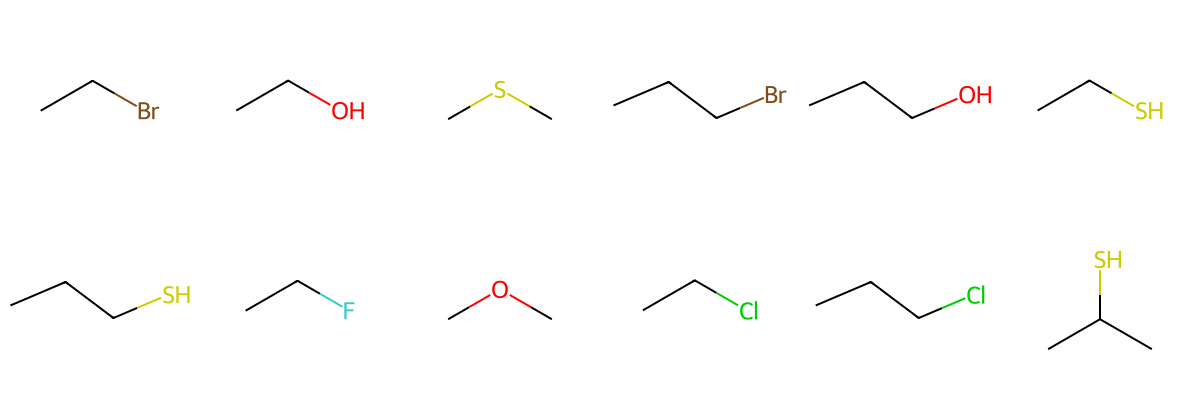

In [27]:
# Show the best compounds
pop_adv = pd.read_csv(f'{model_path}/pop.csv')
best_adv = pop_adv.sort_values(by = pop_adv.columns[3], ascending=False).iloc[:12, [0, 3]]
print(best_adv)

rd_molecules_adv = [Chem.MolFromSmiles(molecules) for molecules in best_adv['smiles']]
Draw.MolsToGridImage(rd_molecules_adv, 
                     molsPerRow=6, 
                     subImgSize=(200,200))

layout computed


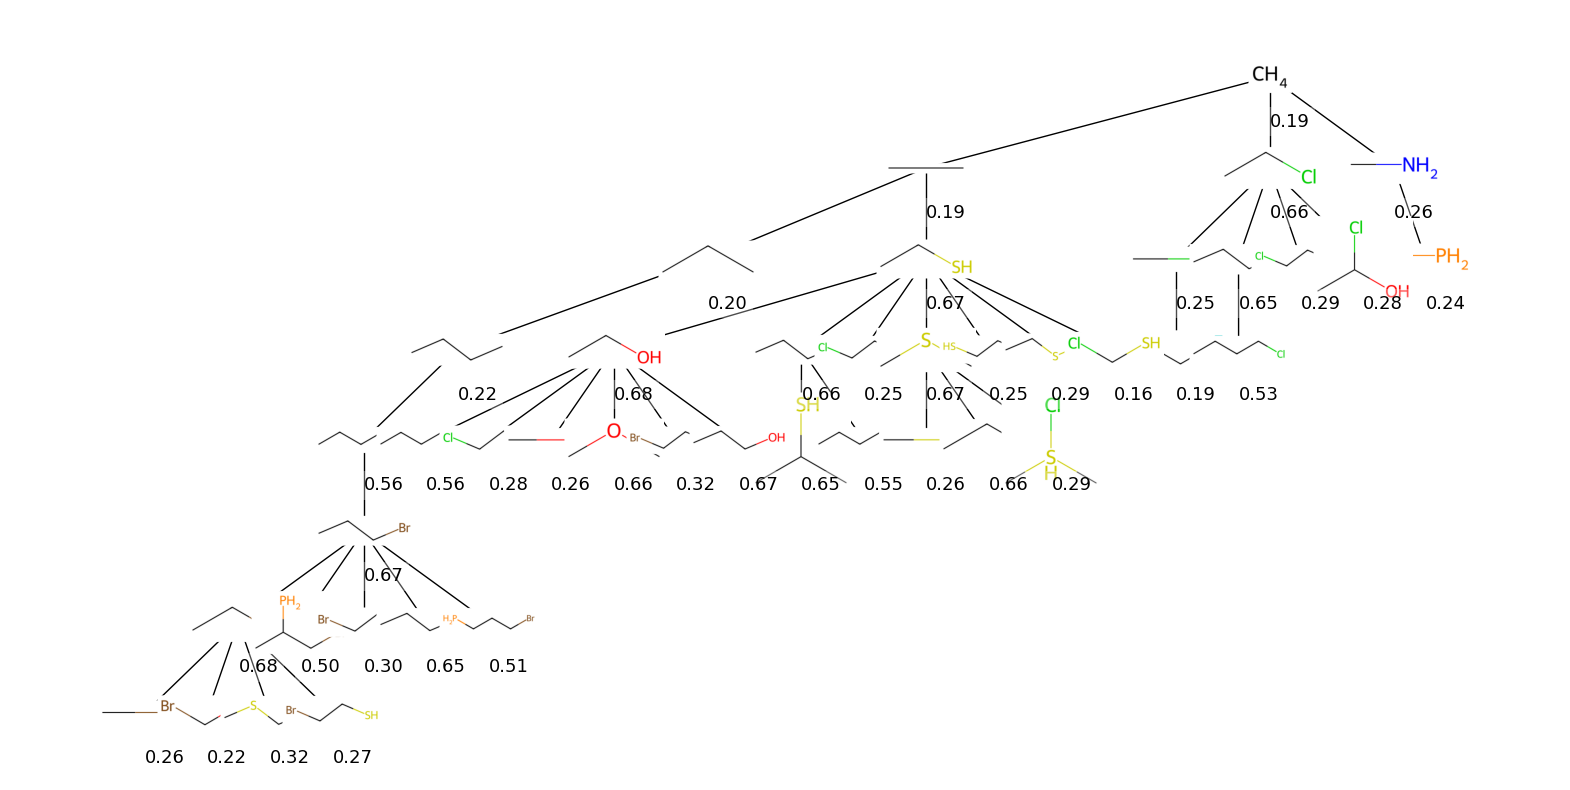

In [28]:
exploration_graph(model_path=model_path, 
                  layout= 'dot', 
                  plot_images=True, 
                  draw_scores=True,
                  root_node="C", # Select the root node
                  legend_scores_keys_strat=["total"], 
                  mol_size_inches=0.1,
                  mol_size_px=(200, 200), 
                  legend_offset=(0, -0.05), 
                  figsize=(20, 10), 
                  legends_font_size=13)

## Longer runs
Let us just re-do the original experiment, but in this case we will run it for 10x longer so that we get a more extensive exploration of the evolutionary process (_this may take a minute..._)

In [29]:
simple_opt_parameters = {
        "max_steps": 100,
}

# We will record the evolutionary process in a different location
model_path = f'{repsol_path}/examples/longer_simple_run'

simple_io_parameters = {
        "model_path": model_path,
        "record_history": True
}

run_model({**simple_obj_function,
           'action_space_parameters' : {**simple_action_parameters}, 
           'optimization_parameters' : {**simple_opt_parameters}, 
           'io_parameters' : {**simple_io_parameters}})

SYMBOLS LIST : ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
objective_calls
Computing scores at initialization...
Start pop algorithm
qed_mean : 0.35978
qed_med : 0.35978
qed_std : 0.00000
qed_min : 0.35978
qed_max : 0.35978
total_mean : 0.35978
total_med : 0.35978
total_std : 0.00000
total_min : 0.35978
total_max : 0.35978
new step
step : 0
best : C
qed_mean : 0.37253
qed_med : 0.37253
qed_std : 0.01275
qed_min : 0.35978
qed_max : 0.38528
total_mean : 0.37253
total_med : 0.37253
total_std : 0.01275
total_min : 0.35978
total_max : 0.38528
new step
step : 1
best : CO
qed_mean : 0.38413
qed_med : 0.38497
qed_std : 0.01665
qed_min : 0.35978
qed_max : 0.40681
total_mean : 0.38413
total_med : 0.38497
total_std : 0.01665
total_min : 0.35978
total_max : 0.40681
new step
step : 2
best : CCO
qed_mean : 0.39800
qed_med : 0.39142
qed_std : 0.02688
qed_min : 0.35978
qed_max : 0.45506
total_mean : 0.39800
total_med : 0.39142
total_std : 0.02688
total_min : 0.35978
total_max : 0.45506
new step
step : 

We can again analyze the best molecules, to see if they come up any different

In [30]:
pop_longer = pd.read_csv(f'{model_path}/pop.csv')
best_compounds_longer = pop_longer.sort_values(by = "qed", ascending=False)[['smiles', 'qed']].iloc[:12]
print('Best new compounds: \n', best_compounds_longer, '\n')
print('Best old compounds: \n', best_compounds)

Best new compounds: 
             smiles       qed
170  BrO[SH](Br)Br  0.730194
724        BrPNPBr  0.728910
287   NS(Br)(Br)Br  0.728109
186   OS(Br)(Br)Br  0.725713
522      NP(Br)SBr  0.711255
508      OP(Br)SBr  0.710473
639      NPP(Br)Br  0.698574
627      NP(Br)PBr  0.698574
590      OP(Br)PBr  0.697827
598      OPP(Br)Br  0.697827
123  Cl[SH](Br)OBr  0.697752
147  ClO[SH](Br)Br  0.697752 

Best old compounds: 
          smiles       qed
32  CC[SH](C)Br  0.552271
25        CCCCN  0.512415
39        CCCNC  0.504854
24        CCCSF  0.504084
29        CCSPF  0.493339
20        CCCCS  0.490253
40     CC(Br)CF  0.487556
41        FCCSP  0.487371
33   CC[SH](C)F  0.470012
30        NCCCS  0.468502
28        CCOCN  0.466505
38   CC[SH](C)O  0.466288


Old molecules:


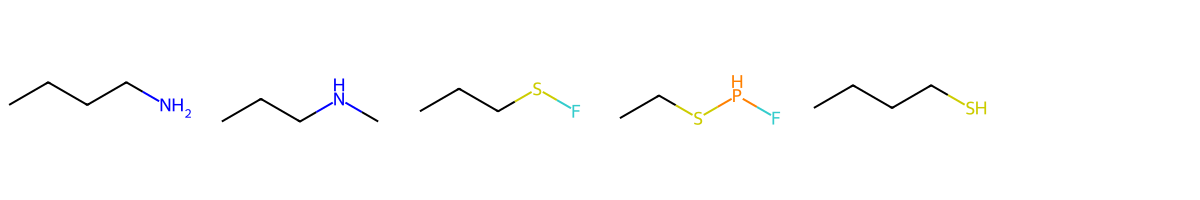

In [33]:
print("Old molecules:")
rd_molecules = [Chem.MolFromSmiles(molecules) for molecules in best_compounds['smiles'][1:6]]
Draw.MolsToGridImage(rd_molecules, molsPerRow=6, subImgSize=(200,200)) 

New molecules:


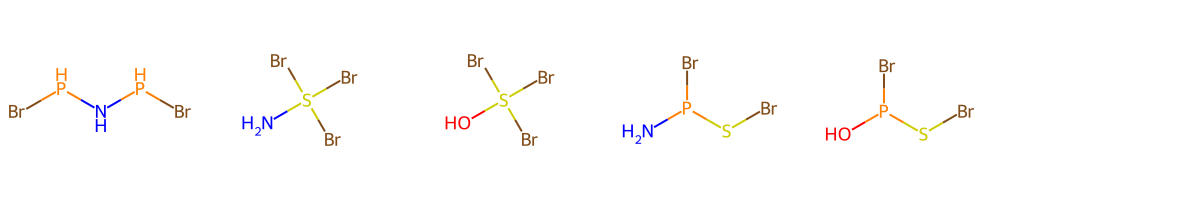

In [34]:
print("New molecules:")
rd_molecules_longer = [Chem.MolFromSmiles(molecules) for molecules in best_compounds_longer['smiles'][1:6]]
Draw.MolsToGridImage(rd_molecules_longer, molsPerRow=6, subImgSize=(200,200))

The molecules that result from longer runs provide a better (higher) value of QED, as could be expected. However, one has to be very careful so that the final results of the run make sense (from a _chemical_ point of view, or even practically)

Representing the results as we did previously, here takes a very long time since we have a very large number of molecules and evolutionary steps. In this case, it may make more sense to just represent the evolutionary tree to get a more intuitive description of the evolution of the QED metric.



layout computed


KeyboardInterrupt: ignored

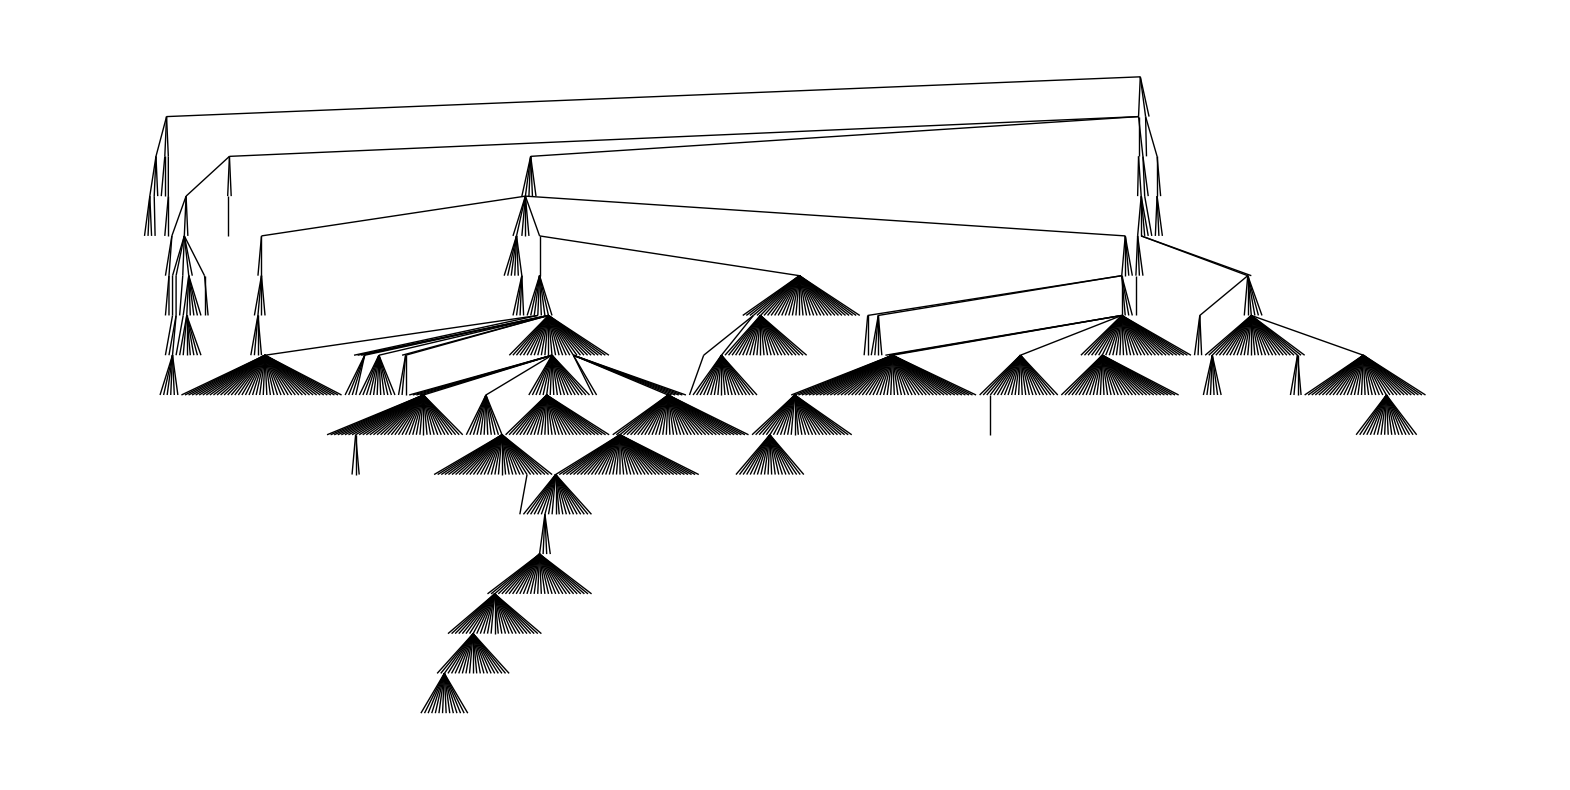

In [ ]:
# Too costly and does not help much...
exploration_graph(model_path=model_path, 
                  layout= 'dot', 
                  plot_images=True, 
                  draw_scores=True,
                  root_node="C", # Select the root node
                  legend_scores_keys_strat=["total"], 
                  mol_size_inches=0.1,
                  mol_size_px=(200, 200), 
                  legend_offset=(0, -0.05), 
                  figsize=(20, 10), 
                  legends_font_size=13)

layout computed


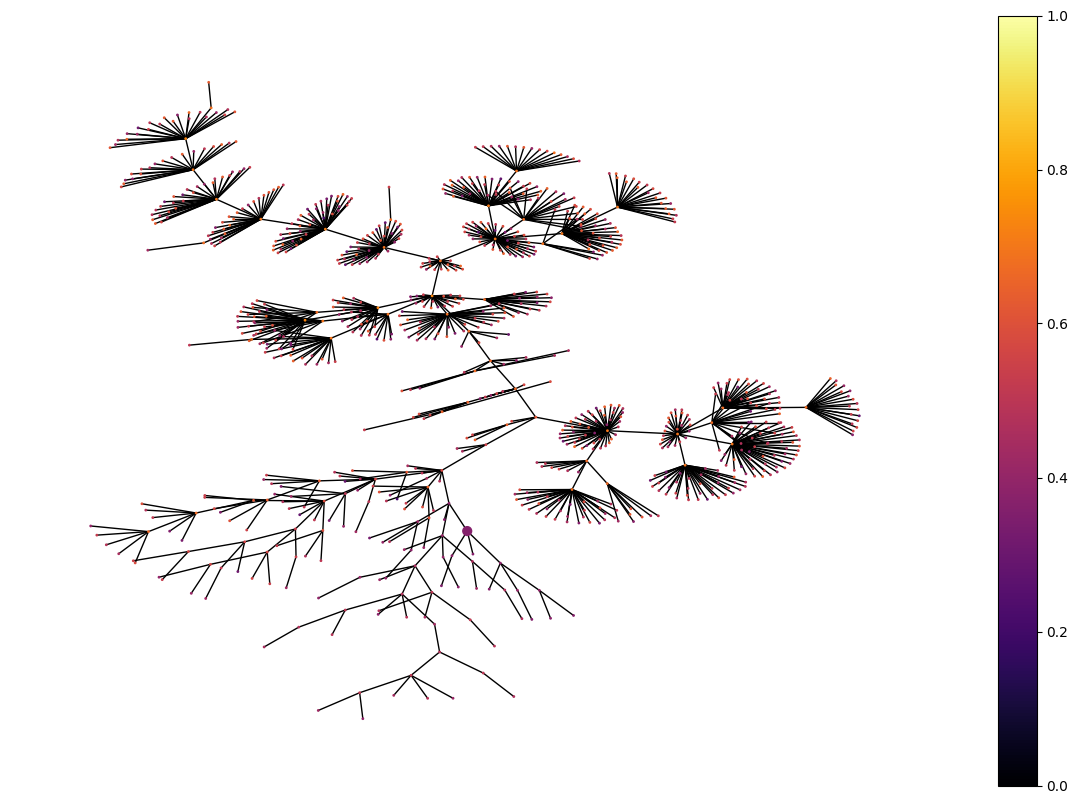

In [35]:
# A better option
exploration_graph(model_path=model_path, layout="neato")

# **A more specific run**

Finally, let us introduce a more practical example. In this case, we will develop a small evolutionary chain to a pre-existing molecule. We will begin from the acetylsalicylic acid molecule as an example:

Original SMILES:  O=C(C)Oc1ccccc1C(=O)O


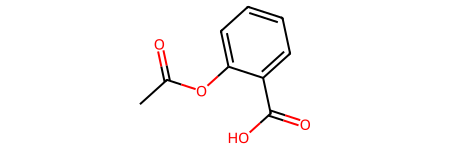

In [36]:
aa_path = f"{repsol_path}/examples/acetylsalicylic_acid.smi"

# More general function, to read a number of molecules from the file if needed
with open(aa_path, "r") as ins:
    smiles = []
    for line in ins:
        smiles.append(line.split('\n')[0])
print("Original SMILES: ",  smiles[0])

Chem.MolFromSmiles(smiles[0])

Let us now briefly run the EvoMol algorithm but in this case let us keep the original population (the acetylsalicylic acid molecule)  

In [37]:
model_path = f"{repsol_path}/examples/aa_run"

run_model({
    "obj_function": "qed",
    "optimization_parameters": {
        "max_steps": 5,
        "pop_max_size": 10,
        "mutable_init_pop": False
    },
    "io_parameters": {
        "model_path": model_path,
        "record_history": True,
        "smiles_list_init_path": f"{repsol_path}/examples/acetylsalicylic_acid.smi"
    }
})

SYMBOLS LIST : ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br']
objective_calls
Computing scores at initialization...
Start pop algorithm
qed_mean : 0.55012
qed_med : 0.55012
qed_std : 0.00000
qed_min : 0.55012
qed_max : 0.55012
total_mean : 0.55012
total_med : 0.55012
total_std : 0.00000
total_min : 0.55012
total_max : 0.55012
new step
step : 0
best : CC(=O)Oc1ccccc1C(=O)O
qed_mean : 0.55437
qed_med : 0.55437
qed_std : 0.00425
qed_min : 0.55012
qed_max : 0.55863
total_mean : 0.55437
total_med : 0.55437
total_std : 0.00425
total_min : 0.55012
total_max : 0.55863
new step
step : 1
best : O=C1C#Sc2cccc(c2C(=O)O)O1
qed_mean : 0.53583
qed_med : 0.55437
qed_std : 0.04399
qed_min : 0.46103
qed_max : 0.57354
total_mean : 0.53583
total_med : 0.55437
total_std : 0.04399
total_min : 0.46103
total_max : 0.57354
new step
step : 2
best : CC(=O)Oc1c(C)cccc1C(=O)O
qed_mean : 0.53080
qed_med : 0.54140
qed_std : 0.04101
qed_min : 0.46103
qed_max : 0.57354
total_mean : 0.53080
total_med : 0.54140
total_std : 

Show the main three compounds generated and their estimated QED values 

                          smiles       qed
1      CC(=O)Oc1c(Br)cccc1C(=O)O  0.651861
8      CC(=O)Oc1ccc(Br)cc1C(=O)O  0.651861
5  CC(=O)Oc1cc(Cl)c(Cl)cc1C(=O)O  0.645853

 Compounds obtained from acetylsalicylic acid evolution:


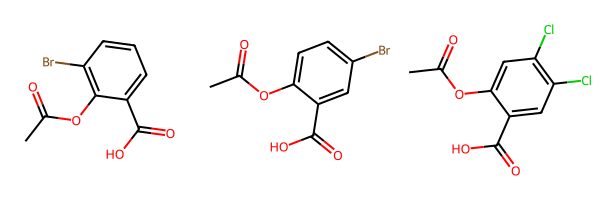

In [55]:
pop_aa = pd.read_csv(f'{model_path}/pop.csv')
best_compounds_aa = pop_aa.sort_values(by = "qed", ascending=False)[['smiles', 'qed']].iloc[:3]
print(best_compounds_aa)

print("\n Compounds obtained from acetylsalicylic acid evolution:")
rd_molecules_longer = [Chem.MolFromSmiles(molecules) for molecules in best_compounds_aa['smiles']]
Draw.MolsToGridImage(rd_molecules_longer, molsPerRow=3, subImgSize=(200,200))



Show the complete evolution

layout computed


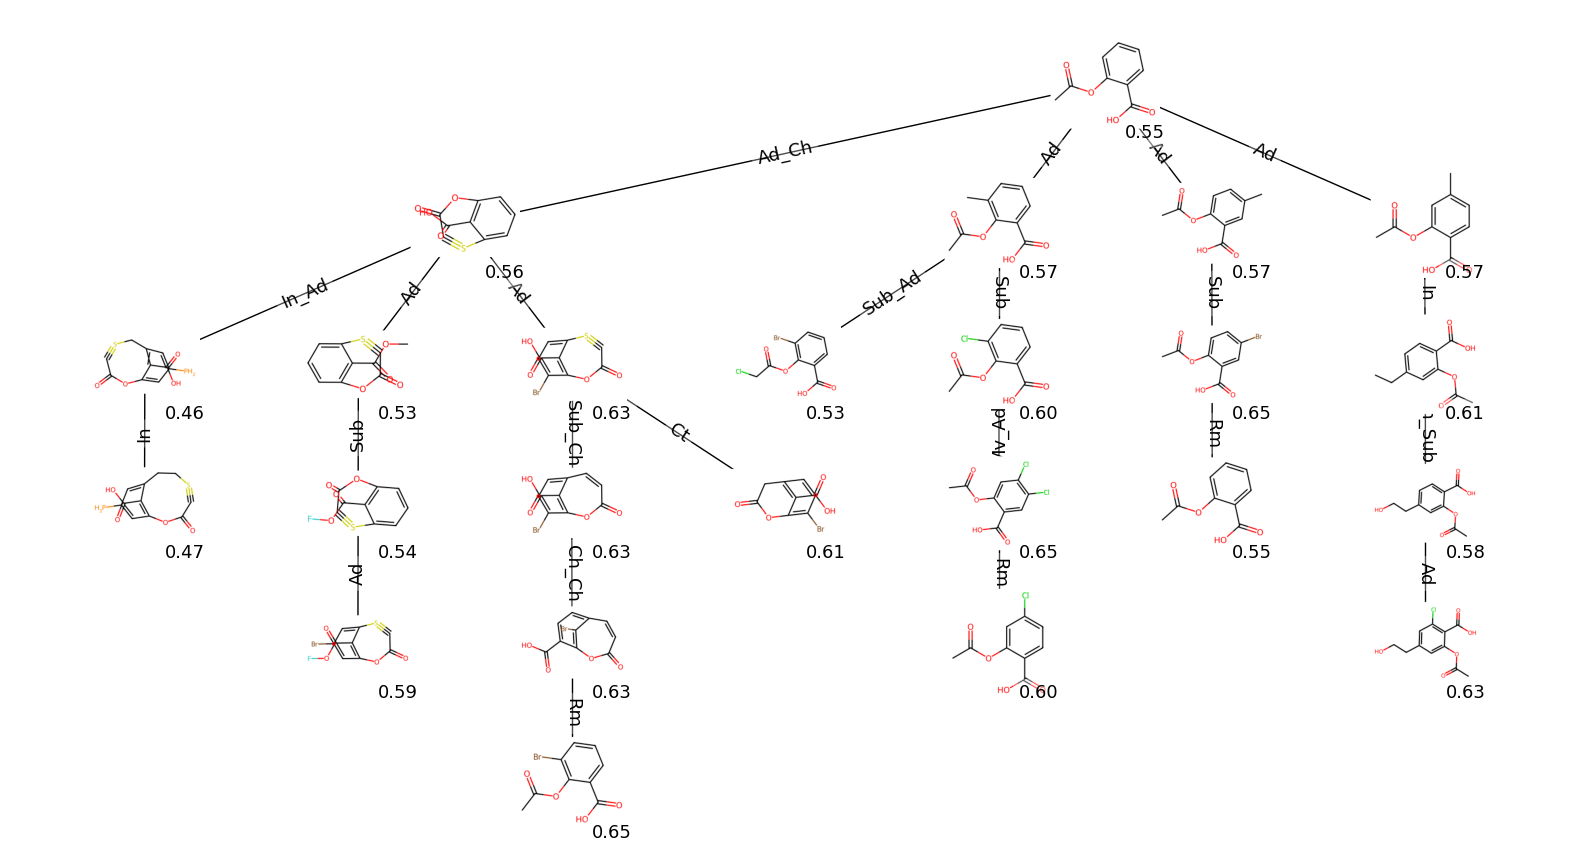

In [46]:
exploration_graph(model_path=model_path, 
                  layout='dot', 
                  draw_actions=True, 
                  plot_images=True, 
                  draw_scores=True,
                  root_node=smiles[0], 
                  legend_scores_keys_strat=["total"], 
                  mol_size_inches=0.1,
                  mol_size_px=(200, 200), 
                  legend_offset=(0.01, -0.05), 
                  figsize=(20, 11), 
                  legends_font_size=13)


Finally, to showcase the effects of a very (_very_) long run, we have this experiment for which the entropy funtion is employed (just for the looks)

layout computed


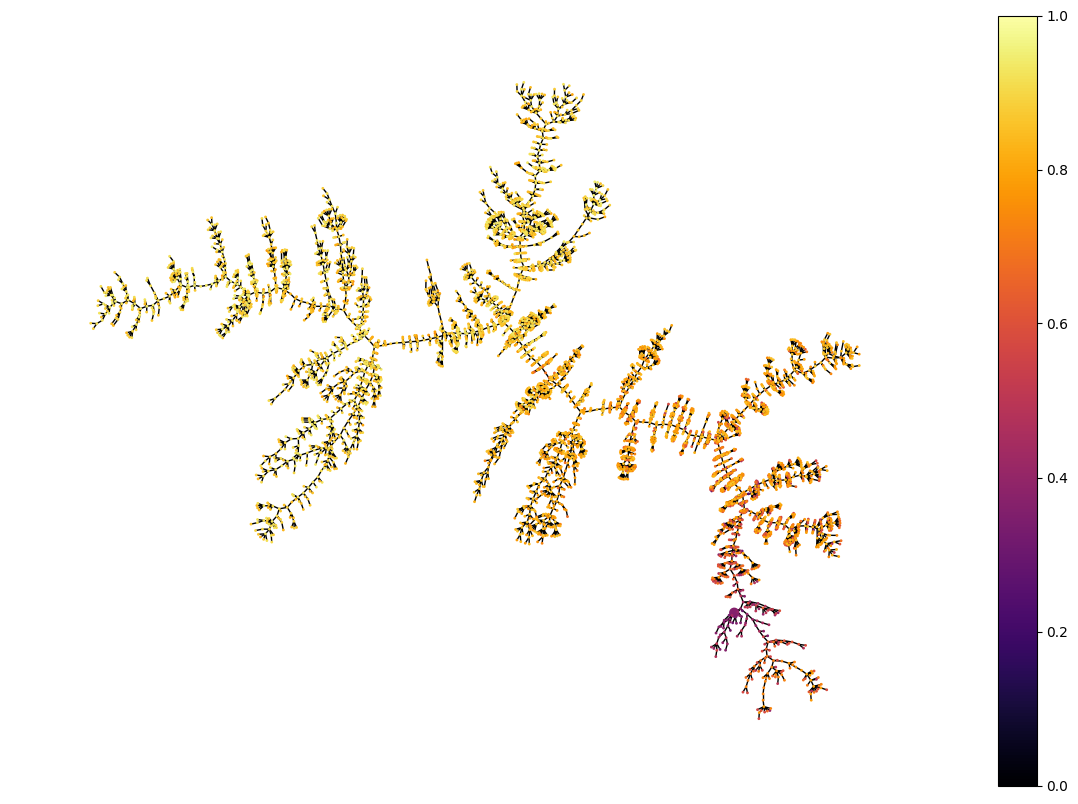

In [56]:
exploration_graph(model_path = f'{repsol_path}/examples/entropy_optimization', layout="neato", prop_to_study_key="qed")